In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy.signal import firwin, lfilter, freqz
from tqdm import tqdm
from IPython.display import display
from scipy import signal
import sympy
import zplane as zp
import biosignalsnotebooks as bsnb


Extracción de la señal

In [255]:
VCC = 3.3
n = 10

Fs = 1000
#cargamos los datos desde el archivo txt
datos = np.loadtxt("preguntas2.txt")
print(datos)
datos = datos[:, 8] #el 5 y 6 contienen la información
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)

frec_muestreo = Fs #por el teorema de Nyquist
tiempo = np.arange(len(datos)) / frec_muestreo


[[  0.   0.   0. ... 580.  39.   0.]
 [  1.   0.   0. ... 588.  39.   0.]
 [  2.   0.   0. ... 591.  39.   0.]
 ...
 [ 11.   0.   0. ... 483.  39.   0.]
 [ 12.   0.   0. ... 498.  39.   0.]
 [ 13.   0.   0. ... 497.  39.   0.]]
[580. 588. 591. ... 483. 498. 497.]


Análisis de la señal sin filtrar en dominio de la frecuencia

[]


IndexError: index 0 is out of bounds for axis 0 with size 0

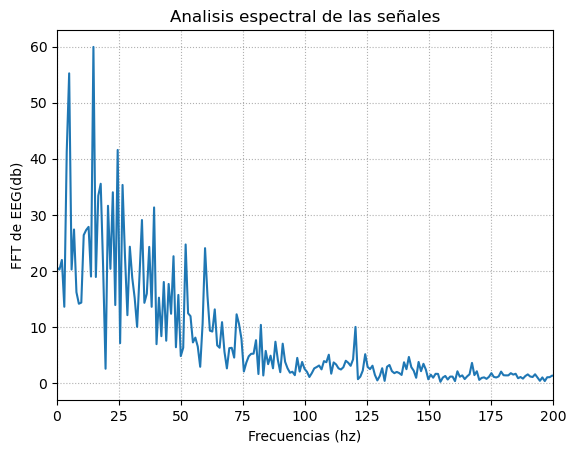

In [256]:
N=2**10 # 10 bits

X = np.fft.fft(datos,N)
X = X[0:N//2]
Xm = np.abs(X)
F = np.linspace(0,Fs/2,N//2)

plt.plot(F, Xm)
plt.grid(linestyle=":")
plt.title("Analisis espectral de las señales")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT de EEG(db)")

peaks, properties = signal.find_peaks(Xm, height=100)
plt.plot(F[peaks],properties["peak_heights"],"x")
plt.xlim([0,200])
print(F[peaks])
plt.text(F[peaks][0],properties["peak_heights"][0], f"{np.round(F[peaks][0],2)} hz")
plt.text(F[peaks][1],properties["peak_heights"][1], f"{np.round(F[peaks][1],2)}")
plt.text(F[peaks][2],properties["peak_heights"][1], f"{np.round(F[peaks][2],2)}")
plt.text(F[peaks][3],properties["peak_heights"][1], f"{np.round(F[peaks][3],2)}")

plt.show()
print(max(Xm))

Diseño de filtro pasa bajo IIR

In [107]:
wp=2*3.1415*35
ws=2*3.1415*60


N_ord, Wc= signal.buttord(wp, ws, gpass=3, gstop=40, analog=True) #gpass=loss in passband edge frecuencies, gstop= attenuation in stopband edge frecuencies 
fc = np.round(Wc/(2*np.pi) ,2) 

print(f"Orden del filtro: {N_ord}")
print(f"Frecuencia de corte calculada: {fc} hz")

Orden del filtro: 9
Frecuencia de corte calculada: 35.01 hz


[1.20544432e+21]
[1.00000000e+00 1.26671658e+03 8.02285443e+05 3.31661002e+08
 9.82895230e+10 2.16200608e+13 3.52974605e+15 4.13121058e+17
 3.15592913e+19 1.20544432e+21]


Text(0, 0.5, 'Magnitud (db)')

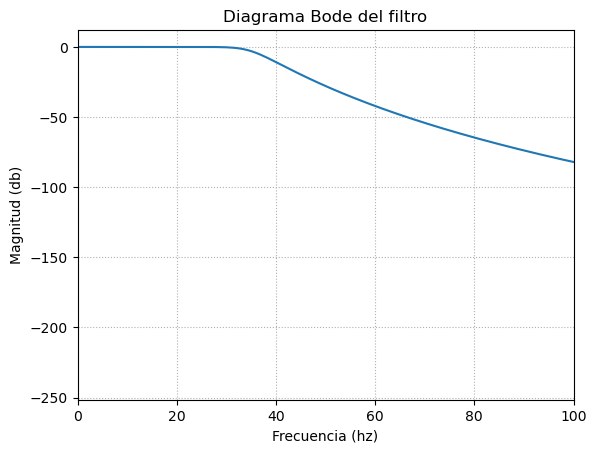

In [108]:
b,a = signal.butter(N_ord, Wc, 'lowpass', True, 'ba')
print(b)
print(a)

# Respuesta en frecuencia del filtro analogico
Fmax=750
F_freqs = np.linspace(0,Fmax,1000)
W_freqs = 2*np.pi*F_freqs  #Angular frecuences

W_freqs, H = signal.freqs(b,a,W_freqs)
Hm=np.abs(H)
plt.plot(F_freqs, 20 * np.log10(Hm))
plt.grid(linestyle=":")
plt.title("Diagrama Bode del filtro")
plt.xlabel("Frecuencia (hz)")
plt.xlim([0,100])
plt.ylabel("Magnitud (db)")

Aplicar filtro IIR

Text(0, 0.5, 'Magnitud (db)')

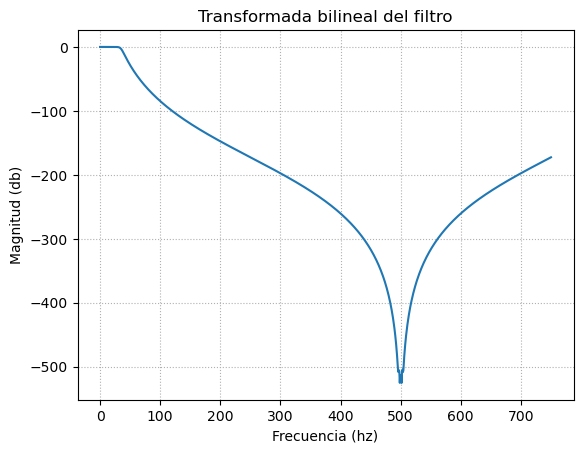

In [109]:
#calculamos la trasformada bilineal
bd, ad = signal.bilinear(b,a,Fs)

Wz, Hd = signal.freqz(bd, ad, W_freqs/Fs)

Hdm = np.abs(Hd)
plt.plot(F_freqs, 20 * np.log10(Hdm))
plt.grid(linestyle=":")
plt.title("Transformada bilineal del filtro")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

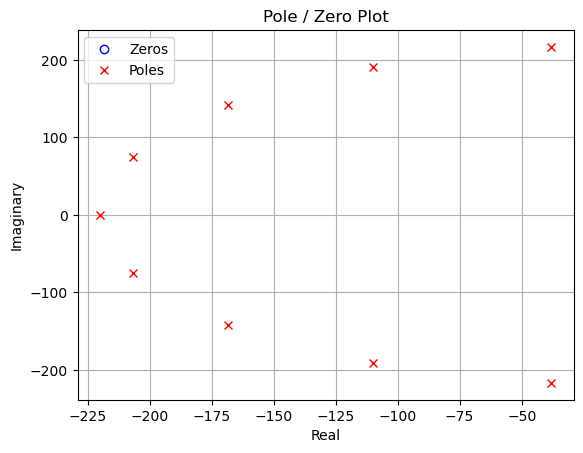

In [110]:
z, p, k = signal.tf2zpk(b, a)

plt.plot(np.real(z), np.imag(z), 'ob', markerfacecolor='none')
plt.plot(np.real(p), np.imag(p), 'xr')
plt.legend(['Zeros', 'Poles'], loc=2)
plt.title('Pole / Zero Plot')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()

Text(0, 0.5, 'mV')

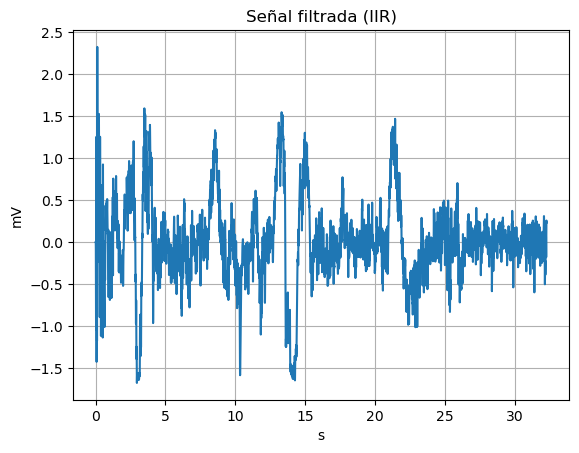

In [111]:
#FILTRADO
t = np.arange(len(datos)) / Fs

y = signal.lfilter(bd,ad, datos) #señal filtrada

#fig, ax = plt.subplots(2,1)
#ax[0].plot(t,y, label="señal filtrada")
#ax[0].legend(loc="upper right")
#ax[0].grid()
#ax[1].plot(t,datos, label="datos")
#ax[1].legend(loc="upper right")
#ax[1].grid()
#ax[1].set_xlabel("tiempo (s)")
plt.plot(t,y, label="señal filtrada")
plt.grid()
plt.title("Señal filtrada (IIR)")
plt.xlabel("s")
plt.ylabel("mV")

Text(0, 0.5, 'mV')

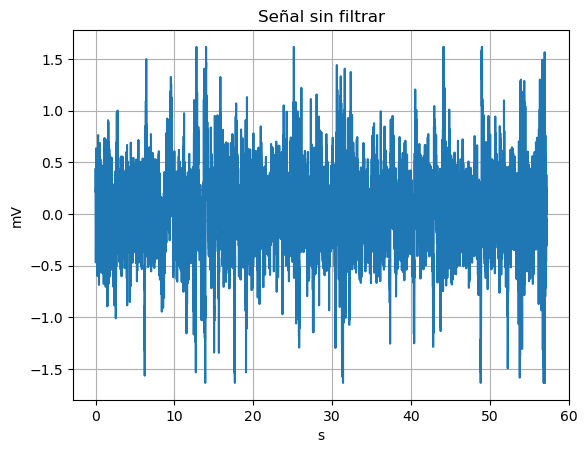

In [290]:
plt.plot(t,datos, label="datos")
plt.grid()
plt.title("Señal sin filtrar")
plt.xlabel("s")
plt.ylabel("mV")

196.92212514046804


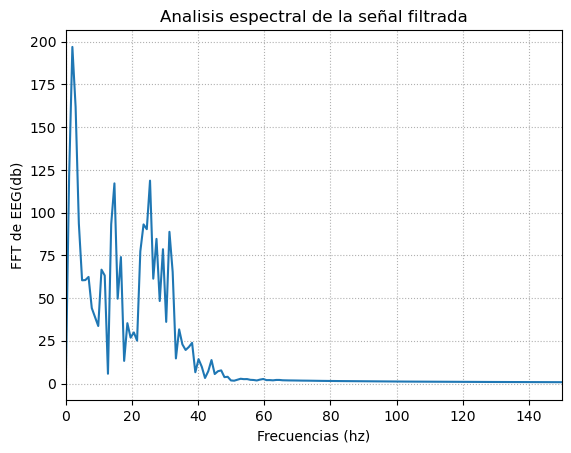

In [113]:
Yf = np.fft.fft(y,N)
Yf = Yf[:N//2]
Ym = np.abs(Yf)

Fd = np.linspace(0, Fs//2, N//2)
plt.plot(Fd, Ym)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal filtrada")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT de EEG(db)")

peaks, properties = signal.find_peaks(Ym, height=500)
plt.plot(Fd[peaks], properties['peak_heights'], "x")
plt.xlim([0,150])
#plt.text(Fd[peaks], properties['peak_heights'], f"{np.round(Fd[peaks][0])} hz")

print(max(Ym))


Diseño de filtro FIR

In [293]:
#longitud de la ventana
M = 200
#frecuencias
#Para reposo se usó fc =8 para obtener los 4 picos que se presnetan
#Para la señal de abrir y cerrar ojos se usó fc=4
fc = 20

# filtro fir
w = firwin(numtaps=M, cutoff=fc, nyq=100, window='hamming')
w = np.round(w,3)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16788\363620713.py:9: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  w = firwin(numtaps=M, cutoff=fc, nyq=100, window='hamming')


(0.0, 100.0)

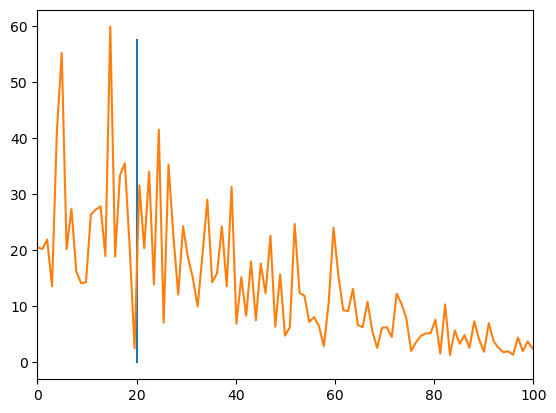

In [294]:
#GRAFICAMOS EL FILTRO CON LA SEÑAL

#magnitud
Rx = fc*np.ones([N//2])
Ry = np.linspace(0,1,N//2)

Ry = np.linspace(0,np.max(X),N//2) #el eje y

plt.plot(Rx,Ry)
plt.plot(F,Xm)
plt.xlim([0,100])

In [295]:
y = lfilter(w, np.array(1),datos)
Y = np.fft.fft(y,N)
Y = np.round(Y[0:N//2],3)

Ym = np.abs(Y)
print(len(y))

57150


(0.0, 100.0)

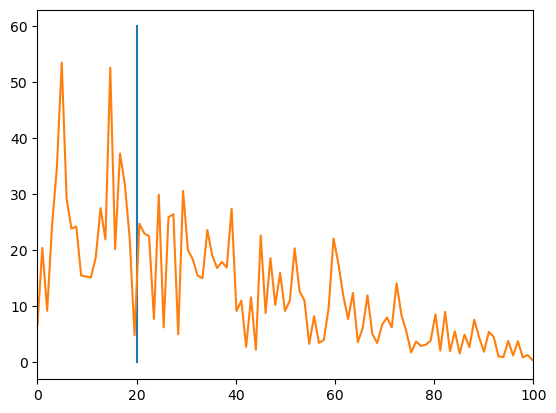

In [296]:
Ry = np.linspace(0,np.max(Xm),N//2) #el eje y

plt.plot(Rx,Ry)
plt.plot(F,Ym)
plt.xlim([0,100])

Text(0, 0.5, 'mV')

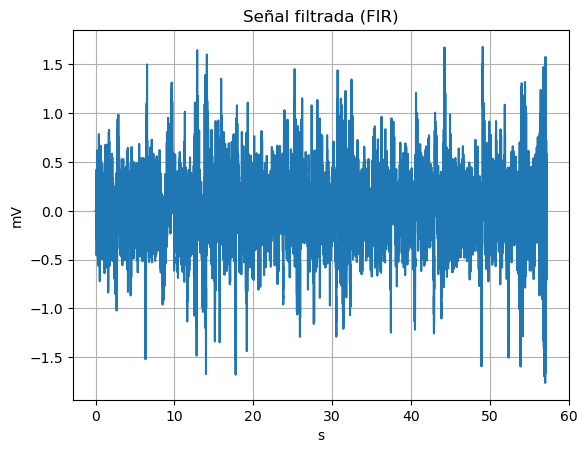

In [297]:
#GRAFICO LA SEÑAL FILTRADA POR FIR LOWPASS
t = np.arange(len(datos)) / Fs
plt.plot(t,y, label="señal filtrada")
plt.grid()
plt.title("Señal filtrada (FIR)")
plt.xlabel("s")
plt.ylabel("mV")

Diseño de un highpass FIR para completar passband

In [251]:
#AGREGAREMOS UN HIGHPASS FILTER
#No se usó para la señal de reposo por que habían varias ondas presentes
#Se usó una fc de 4 para la señal de abrir y cerrar ojos
#No se usó para la señal de preguntas ya que habían 2 ondas: alfa y beta

#longitud de la ventana
M = 101
#frecuencias
fch = 0.5


# filtro fir
wh = firwin(numtaps=M, cutoff=fch, nyq=100, pass_zero=False, window='hamming')
wh = np.round(wh,3)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16788\2717034484.py:13: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  wh = firwin(numtaps=M, cutoff=fch, nyq=100, pass_zero=False, window='hamming')


(0.0, 40.0)

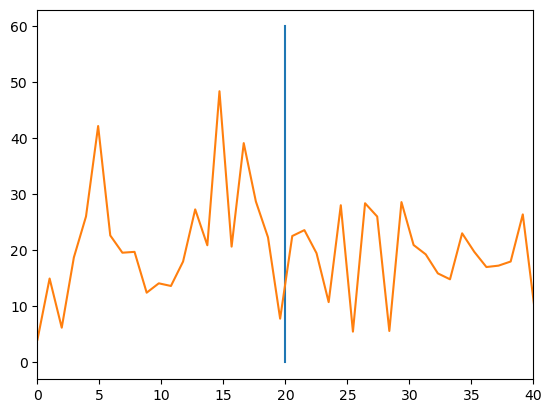

In [291]:
yh = lfilter(wh, np.array(1),y)
Yh = np.fft.fft(yh,N)
Yh = np.round(Yh[0:N//2],3)

Ymh = np.abs(Yh)

Ryh = np.linspace(0,np.max(Xm),N//2) #el eje y

plt.plot(Rx,Ryh)
plt.plot(F,Ymh)
plt.xlim([0,40])

Text(0, 0.5, 'mV')

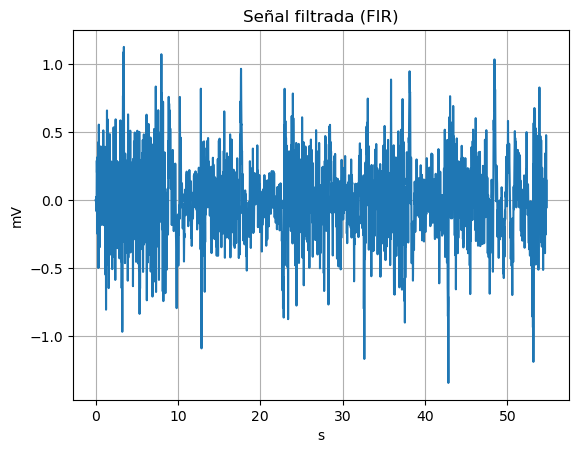

In [254]:
#GRAFICO LA SEÑAL FILTRADA POR FIR HIGHPASS
t = np.arange(len(datos)) / Fs
plt.plot(t,yh, label="señal filtrada")
plt.grid()
plt.title("Señal filtrada (FIR)")
plt.xlabel("s")
plt.ylabel("mV")